# 17. 다음에 볼 영화 예측하기

# ◈ 프로젝트 - Movielens 영화 SBR

이번에도 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

1) wget으로 데이터 다운로드

$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip


2) 다운받은 데이터를 작업디렉토리로 이동

$ mv ml-1m.zip ~/aiffel/yoochoose-data


3) 압축 해제

$ cd ~/aiffel/yoochoose-data && unzip ml-1m.zip

In [1]:
from pathlib import Path
import os
import datetime as dt

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

In [2]:
# README 보기 

f = open(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m/README', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

SUMMARY




These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 

made by 6,040 MovieLens users who joined MovieLens in 2000.



USAGE LICENSE




Neither the University of Minnesota nor any of the researchers

involved can guarantee the correctness of the data, its suitability

for any particular purpose, or the validity of results based on the

use of the data set.  The data set may be used for any research

purposes under the following conditions:



     * The user may not state or imply any endorsement from the

       University of Minnesota or the GroupLens Research Group.



     * The user must acknowledge the use of the data set in

       publications resulting from the use of the data set

       (see below for citation information).



     * The user may not redistribute the data without separate

       permission.



     * The user may not use this information for any commercial or

       revenue-bearing purposes without first obtaining permi

## `"ratings.dat"`  format:
### `UserID::MovieID::Rating::Timestamp`



## `"users.dat"`  format:
### `UserID::Gender::Age::Occupation::Zip-code`



## `"movies.dat"` format:
### `MovieID::Title::Genres`


### genres 종류:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western



In [3]:
#영화 데이터 불러오기 
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 

train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)

data.sort_values(['UserId', 'Time'], inplace=True)  # data를 userid와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


-  SessionID대신 UserID항목
-  Rating정보
-  Time 항목에는 UTC time이 포함

In [4]:
#데이터의 통계정보 
data.describe()

,UserId,ItemId,Rating,Time
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


## Step 1. 데이터의 전처리
- 항목별 기본분석
- Session length, Session time, cleaning 등의 작업을 진행
- Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의한다.

In [5]:
data.iloc[0]['Time']

978300019

In [6]:
data.loc[0]

UserId            1
ItemId         1193
Rating            5
Time      978300760
Name: 0, dtype: int64

In [7]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [8]:
userid_length = data.groupby('UserId').size()
userid_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [9]:
item_length = data.groupby('ItemId').size()
item_length

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

In [10]:
#- 사용자가 리뷰를 남기는 횟수를 의미
#- 일반적으로 96~165개의 영화 리뷰
userid_length.median(), userid_length.mean()

(96.0, 165.5975165562914)

In [11]:
# -최소 리뷰, 최대 리뷰
userid_length.min(), userid_length.max()

(20, 2314)

In [12]:
# 99.9% 세션은 길이
userid_length.quantile(0.999)

1343.181000000005

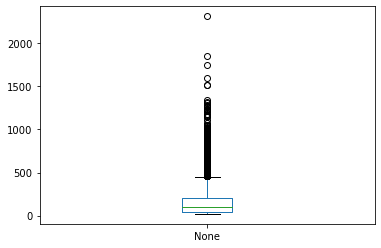

In [13]:
userid_length.plot.box()
plt.show()

In [14]:
#가장긴 리뷰의 데이터 찾기 
long_userid = userid_length[userid_length==2314].index[0]
print("가장 긴 UserId :", long_userid)
data[data['UserId']==long_userid]

가장 긴 UserId : 4169


,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [15]:
length_count = userid_length.groupby(userid_length).size()
length_percent_cumsum = userid_length.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

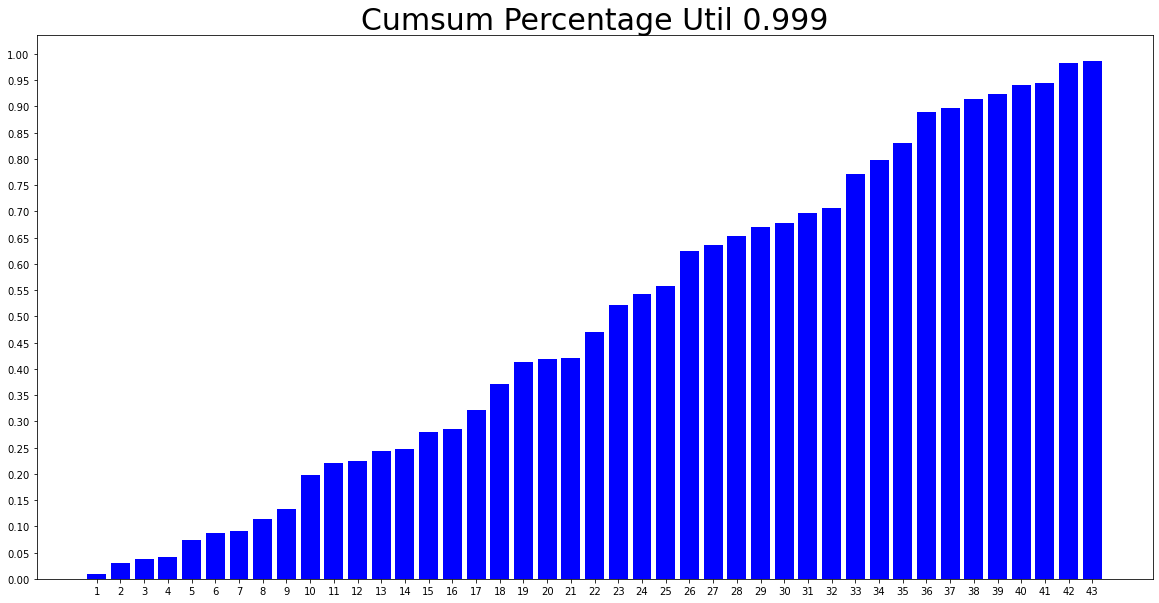

In [16]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
       height=length_percent_cumsum_999, color='blue')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title("Cumsum Percentage Util 0.999", size=20, fontsize=30)
plt.show()

In [17]:
data.isnull().sum()

UserId    0
ItemId    0
Rating    0
Time      0
dtype: int64

#### ```datetime.timedelta``` 활용하기
- ```datetime.timedelta()```에서 ```seconds```인자를 활용해서  
1970년 01월 01년 기준으로 언제 작성한 리뷰인지 새로운 칼럼 ```Datetime```을 생성한다
  
```python
import datetime as dt

datetime.timedelta(seconds=978300019)
>>> datetime.timedelta(days=11322, seconds=79219)

data.Datetime[0]
>>> Timestamp('1970-01-01 00:00:00.019700101')

data.Datetime[0] + datetime.timedelta(seconds=978300019)
>>> Timestamp('2000-12-31 22:00:19.019700101')
```

In [18]:
#시간 데이터를 Ymd HMS로 변환
data['Datetime'] = '1970-01-01 00:00:00'
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%Y-%m-%d %H:%M:%S")
print(data.dtypes)
data

UserId               int32
ItemId               int32
Rating               int32
Time                 int64
Datetime    datetime64[ns]
dtype: object


,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,1970-01-01
22,1,1270,5,978300055,1970-01-01
27,1,1721,4,978300055,1970-01-01
37,1,1022,5,978300055,1970-01-01
24,1,2340,3,978300103,1970-01-01
...,...,...,...,...,...
1000019,6040,2917,4,997454429,1970-01-01
999988,6040,1921,4,997454464,1970-01-01
1000172,6040,1784,3,997454464,1970-01-01
1000167,6040,161,3,997454486,1970-01-01


In [19]:
#현재 시간으로 변환
data.Datetime = data.Datetime + data.Time.map(lambda x : dt.timedelta(seconds=x))
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


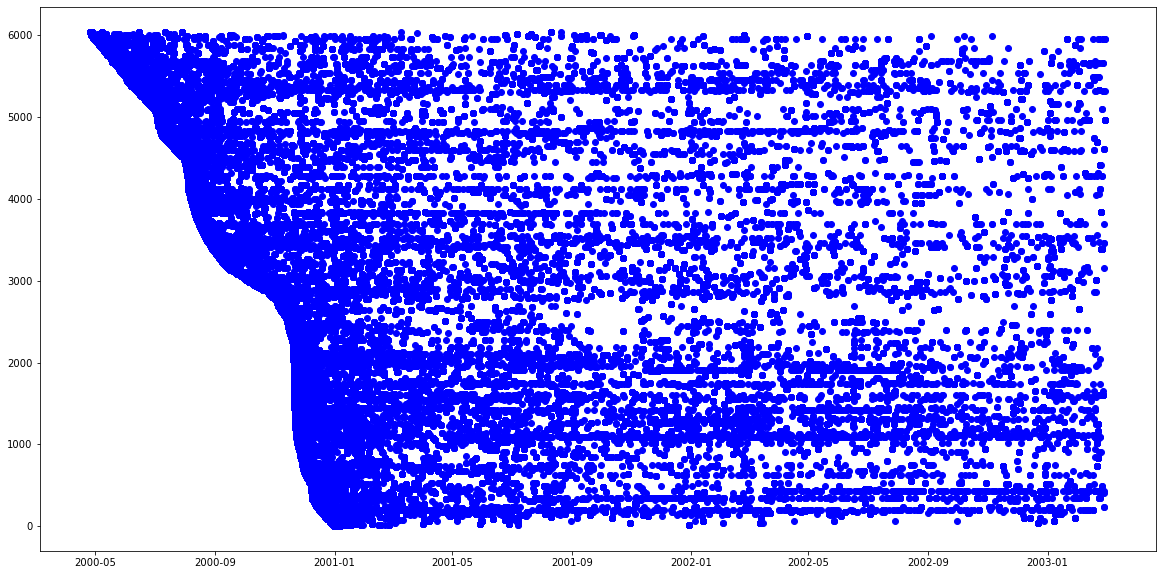

In [20]:
plt.figure(figsize=(20, 10))
plt.scatter(x=data.Datetime, 
           y=data.UserId,
           color ='blue')
plt.show()

In [22]:
oldest = data['Datetime'].min()
latest = data['Datetime'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [23]:
origin_data = data.copy()

In [25]:
data['Datetime'].max() -  data['Datetime'].min()

Timedelta('1038 days 18:44:18')

In [26]:
test_days = latest - dt.timedelta(15)
test_days

Timestamp('2003-02-13 17:49:50')

In [27]:
valid_days = test_days - dt.timedelta(90)
valid_days

Timestamp('2002-11-15 17:49:50')

In [28]:
train_data = data[data['Datetime'] <= valid_days]
test_data = data[data['Datetime'] > test_days]

temp_data = data[data['Datetime'] <= test_days]
valid_data = temp_data[temp_data['Datetime'] > valid_days]

In [29]:
train_data['Datetime'].min(), train_data['Datetime'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2002-11-15 16:08:13'))

In [30]:
valid_data['Datetime'].min(), valid_data['Datetime'].max()

(Timestamp('2002-11-15 20:19:05'), Timestamp('2003-02-13 16:36:54'))

In [31]:
test_data['Datetime'].min(), test_data['Datetime'].max()

(Timestamp('2003-02-13 18:06:30'), Timestamp('2003-02-28 17:49:50'))

In [32]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Datetime"].min()}\n'
          f'\t Last Time : {data["Datetime"].max()}\n')

In [33]:
stats_info(train_data, 'train')
stats_info(valid_data, 'valid')
stats_info(test_data, 'test')

* train Set Stats Info
	 Events: 994758
	 Sessions: 6039
	 Items: 3706
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-11-15 16:08:13

* valid Set Stats Info
	 Events: 4794
	 Sessions: 243
	 Items: 1820
	 First Time : 2002-11-15 20:19:05
	 Last Time : 2003-02-13 16:36:54

* test Set Stats Info
	 Events: 657
	 Sessions: 68
	 Items: 538
	 First Time : 2003-02-13 18:06:30
	 Last Time : 2003-02-28 17:49:50



In [34]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train_data['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train_data = indexing(train_data, id2idx)
valid_data = indexing(valid_data, id2idx)
test_data = indexing(test_data, id2idx)

In [41]:
train_data

,UserId,ItemId,Rating,Time,Datetime,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,3
24,1,2340,3,978300103,2000-12-31 22:01:43,4
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,1248
999988,6040,1921,4,997454464,2001-08-10 14:41:04,370
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,89
1000167,6040,161,3,997454486,2001-08-10 14:41:26,464


In [42]:
valid_data

,UserId,ItemId,Rating,Time,Datetime,item_idx
5200,36,2269,5,1040544350,2002-12-22 08:05:50,1421
5256,36,1701,4,1040544350,2002-12-22 08:05:50,493
5184,36,2694,3,1040544494,2002-12-22 08:08:14,866
5364,36,3786,4,1040544521,2002-12-22 08:08:41,226
5262,36,2369,4,1040544564,2002-12-22 08:09:24,934
...,...,...,...,...,...,...
983996,5948,3467,5,1043068562,2003-01-20 13:16:02,1616
984079,5948,1938,5,1043068730,2003-01-20 13:18:50,2096
984043,5948,1511,4,1044110682,2003-02-01 14:44:42,3055
984001,5948,261,4,1044190885,2003-02-02 13:01:25,1108


In [43]:
test_data

,UserId,ItemId,Rating,Time,Datetime,item_idx
27895,195,2247,2,1045356507,2003-02-16 00:48:27,1402
27846,195,1356,2,1045358834,2003-02-16 01:27:14,549
27901,195,1374,3,1045358834,2003-02-16 01:27:14,740
27902,195,1375,2,1045358834,2003-02-16 01:27:14,641
28241,195,329,2,1045358834,2003-02-16 01:27:14,670
...,...,...,...,...,...,...
984731,5950,3948,4,1046369637,2003-02-27 18:13:57,517
984682,5950,3578,4,1046369670,2003-02-27 18:14:30,95
984475,5950,3793,3,1046369710,2003-02-27 18:15:10,259
984660,5950,3555,2,1046369737,2003-02-27 18:15:37,1724


In [35]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train_data.to_pickle(save_path / 'train.pkl')
valid_data.to_pickle(save_path / 'valid.pkl')
test_data.to_pickle(save_path / 'test.pkl')

In [36]:
val = np.zeros(valid_data['UserId'].nunique() + 1, dtype=np.int32)
val[1:] = valid_data.groupby('UserId').size().cumsum()

In [37]:
tt = origin_data.copy()
tt

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [38]:
tt.drop('Rating', axis=1, inplace=True)
tt.drop('Time', axis=1, inplace=True)
tt

,UserId,ItemId,Datetime
31,1,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,1,2340,2000-12-31 22:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29
999988,6040,1921,2001-08-10 14:41:04
1000172,6040,1784,2001-08-10 14:41:04
1000167,6040,161,2001-08-10 14:41:26


In [39]:
tt = indexing(tt, id2idx)

## Step 2. 미니 배치의 구성
- Session-Parallel Mine-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성
- step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch가 굳이 필요하지 않을 수도 있다.

In [48]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [50]:
train_dataset = SessionDataset(train_data)
train_dataset.df

,UserId,ItemId,Rating,Time,Datetime,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,3
24,1,2340,3,978300103,2000-12-31 22:01:43,4
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,1248
999988,6040,1921,4,997454464,2001-08-10 14:41:04,370
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,89
1000167,6040,161,3,997454486,2001-08-10 14:41:26,464


In [52]:
train_dataset.click_offsets

array([     0,     53,    182, ..., 994294, 994417, 994758], dtype=int32)

In [53]:
train_dataset.session_idx

array([   0,    1,    2, ..., 6036, 6037, 6038])

In [54]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = int((end - start).min() - 1)  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        print(self.dataset.session_idx)
        print(first_iters)
        print(len(first_iters))
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
#         print(np.arange(self.batch_size))
#         print((end - start) == 1)
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [55]:
train_dataset_loader = SessionDataLoader(train_dataset, batch_size=2048)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Datetime,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,3
24,1,2340,3,978300103,2000-12-31 22:01:43,4
36,1,1836,5,978300172,2000-12-31 22:02:52,5
3,1,3408,4,978300275,2000-12-31 22:04:35,6
7,1,2804,5,978300719,2000-12-31 22:11:59,7
47,1,1207,4,978300719,2000-12-31 22:11:59,8
0,1,1193,5,978300760,2000-12-31 22:12:40,9


In [56]:
train_dataset.df.nunique()

UserId        6039
ItemId        3706
Rating           5
Time        454580
Datetime    454580
item_idx      3706
dtype: int64

## Step 3. 모델 구성
- 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있다.

In [57]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [58]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [59]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [60]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train_data, valid_data, test_data, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [61]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(50, 1, 3706)]           0         
_________________________________________________________________
GRU (GRU)                    [(50, 50), (50, 50)]      563700    
_________________________________________________________________
dropout (Dropout)            (50, 50)                  0         
_________________________________________________________________
dense (Dense)                (50, 3706)                189006    
Total params: 752,706
Trainable params: 752,706
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습
- 다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 한다.
- 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 한다.

In [62]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [69]:
train_model(model, args)

Train:   0%|          | 0/19774 [00:00<?, ?it/s, accuracy=0.08, train_loss=5.17]

[   0    1    2 ... 6036 6037 6038]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50


Evaluation:   0%|          | 0/91 [00:00<?, ?it/s]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242]
[ 0  1  2  3 

Train:   0%|          | 0/19774 [00:00<?, ?it/s, accuracy=0.14, train_loss=5.12]

	 - Recall@20 epoch 1: 0.169057
	 - MRR@20    epoch 1: 0.050399

[   0    1    2 ... 6036 6037 6038]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50


Evaluation:   0%|          | 0/91 [00:00<?, ?it/s]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242]
[ 0  1  2  3 

Train:   0%|          | 0/19774 [00:00<?, ?it/s, accuracy=0.06, train_loss=5.09]

	 - Recall@20 epoch 2: 0.173208
	 - MRR@20    epoch 2: 0.051218

[   0    1    2 ... 6036 6037 6038]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50


Evaluation:   0%|          | 0/91 [00:00<?, ?it/s]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242]
[ 0  1  2  3 

Evaluation:  58%|█████▊    | 53/91 [00:08<00:06,  6.09it/s]

	 - Recall@20 epoch 3: 0.173208
	 - MRR@20    epoch 3: 0.052023



## Step 5. 모델 테스트
- 미리 구성한 테스트셋을 바탕으로 Recall, MRR을 확인# Step 1. 데이터의 전처리

In [64]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [68]:
test_model(model, args, test_data)

Evaluation:   0%|          | 0/11 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50
	 - Recall@20: nan
	 - MRR@20: nan



- 이전 실습과 다른 부분은 SessionID대신 UserID항목이 들어갔다.
    - 명확한 1회 세션의 SessionID를 포함하지 않고 있다.
    - 이번에는 UserID가 SessionID역하을 해야 한다.
- Rating정보가 포함되어 있다.
    - 직전에 봣던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있다.
    - Rating이 낮은 데이터를 어떻게 저리할지도 고민해야 한다.
- Time 항목에는 UTC time이 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

    • 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.
    
    • Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.
    
    • Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.
    
위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

데이터 설명을 읽어보면 몇 가지 주목할만한 점이 있습니다.
1. 유저에 대한 정보를 전혀 알 수 없습니다. (성별, 나이, 장소, 마지막 접속 날짜, 이전 구매 내역 등등 )  
2. 아이템에 대한 정보도 전혀 알 수 없습니다. (실제로 어떤 물건인지, 사진이나 설명, 가격)  
이와 달리 유저에 대한 정보를 알 수 있는 경우는 보통 Sequential Recommendation 이라고 구별해서 부르기도 합니다.

유저와 아이템의 추가 정보를 Sequential Recommendation 모델에 적용하는 분야는 Context-Aware 라는 키워드로 활발히 연구되고 있습니다.

또한 E-Commerce 데이터의 경우 다음과 같은 특징을 갖는다고 합니다.

1. 비로그인 상태로 탐색하는 유저가 많습니다.  
2. 로그인 상태로 탐색한다고 할지라도 접속할 때 마다 탐색하는 의도가 뚜렷하게 다릅니다.  

즉, 마우스를 사야겠다고 마음먹고 탐색한 이력이 칫솔을 사야겠다 생각하고 탐색하는 경우에 도움이 되지 않습니다.

# 17-2. Data Preprocess

# 2.1 Data Load
    • 데이터를 불러와 살펴보고 주요 통계치들을 살펴봅시다.  
    • 이번 자료에서는 Click 데이터에 있는 Session Id, TimeStamp, ItemId 칼럼만 사용하겠습니다  
아래 명령어를 실행해서 만약 pathlib이 설치 되어있지않다면,  

$ pip list | grep pathlib    

아래와 같이 추가로 설치해 주세요. 

$ pip install pathlib    

pathlib 라이브러리에 대한 내용은 이쪽을 참고해주세요.    

In [21]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [22]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data') 
train_path = data_path / 'yoochoose-clicks.dat'
train_path

PosixPath('/home/aiffel-dj56/aiffel/yoochoose-data/yoochoose-clicks.dat')

In [23]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [ ]:
# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해 주세요. 
data = load_data(train_path, None)
data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수 입니다.

In [ ]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(9249729, 52739)
세션의 숫자가 900만개, 아이템 숫자는 5만개가 됩니다.

이 수치가 유저의 수가 900만명이라는 것은 아닙니다. 같은 유저가 여러 개의 세션을 만들수도 있기 때문입니다.

# 2.2 Session Length
각 세션이 대략 몇 개의 클릭 데이터를 갖는지도 살펴보겠습니다.  

In [ ]:
session_length = data.groupby('SessionId').size()
session_length

In [ ]:
item_length = data.groupby('ItemId').size()
item_length

여기서 session_length란 같은 SessionId를 공유하는 데이터 row의 개수를 의미합니다. 

여기서 SessionId란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자입니다.  
로그인하지 않았기 때문에 이 사용자가 누군지는 알수 없어도,  
최소한 특정 사용자의 행동을 SessionId 기준으로 모아서 분류해낼 수는 있습니다.  

따라서 여기서 session_length란 해당 세션의 사용자가 그 세션 동안 몇번의 액션을 취했는지(몇개의 상품정보를 클릭했는지)의 의미가 됩니다.

In [ ]:
session_length.median(), session_length.mean()

In [ ]:
session_length.min(), session_length.max()

In [ ]:
# 99.9% 세션은 길이
session_length.quantile(0.999)

각 세션의 길이는 보통 2~3 정도입니다. 온라인에서 쇼핑할 때를 생각해보면 이 수치가 그럴듯하게 느껴집니다.

99.9% 세션은 길이가 41이하입니다.
길이가 200인 세션은 뭔가 이상합니다.

하나를 잡고 살펴봅시다.

In [ ]:
long_session = session_length[session_length==200].index[0]
data[data['SessionId']==long_session]

매우 짧은 간격으로 지속적으로 클릭을 1시간 30분 가량 지속하고 있습니다.
유저들의 서비스 이용행태는 다양하기 때문에 데이터 전처리를 어떻게 할지는 모델을 만드는 사람이 판단해야 합니다.

e.g.) 음악 데이터의 경우 어떤 사람은 하루종일 랜덤재생을 할 수도 있습니다. 이 유저의 데이터를 그대로 사용하는 게 좋을까요?

e.g.) 어떤 상품의 경우 1분 내에 20명이 10점을 주고 나갈 수도 있습니다. 이 상품을 팔기 위해 조작하고 있는 건 아닐까요?

너무 긴 세션을 제거할 수도 있고 포함시킬 수도 있습니다. 어떻게 하면 좋을지 판단해보세요.

세션 길이에 대한 감을 더 잘 파악하기 위해 시각화를 해보겠습니다. 아래는 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것입니다.

In [ ]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Q1. 추천시스템은 유저-상품 관계 매트릭스를 유저 행렬과 상품 행렬의 곱으로 표현하는 Matrix Factorization 모델을 널리 사용합니다. 
그렇다면 이 데이터도 유저와 클릭한 상품정보 관계에 대해 Matrix Factorization을 사용하면 어떨까요?
제출    
예시답안  
User * Item Matrix의 빈칸이 너무 많아서(data sparsity) 모델이 제대로 학습되지 않을 가능성이 있다. 이 세션정보는 유저를 ID 기반으로 정리할 수 없기 때문에 세션 하나를 유저 하나로 본다면 기존의 유저-상품정보 Matrix보다 훨씬 sparse한 형태가 된다.

# 2.3 Session Time
    • 어떤 유저가 아이폰을 구매하려고 합니다. 2020년 5월에는 아이폰SE2를 구매하려는 사람이 많을 것입니다.  
    • 그러나 그로부터 몇달 후면 아이폰 12의 구매량이 엄청나게 증가하게 될 것입니다.  
    • 영화나 드라마 역시 마찬가지입니다. 유저들의 소비 패턴을 금방금방 변합니다.  
    • 이런 이유 때문에 추천시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요합니다. 이번에는 데이터가 발생한 시간에 대해 알아봅시다.  
    
### Q2. 추천 시스템에서 다루는 시간 관련 데이터는 다양한 측면이 있습니다. 데이터 생성 날짜 말고 또 어떤 요소가 있을까요?
제출    
예시답안  
접속하는 시간대(오전, 오후, 새벽), 접속해 있는 시간, 접속하는 요일, 계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등등  

그렇다면 우리가 다루려는 데이터의 시간 관련 정보를 확인해 봅시다.

In [ ]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

데이터 설명대로 6개월치 데이터가 있습니다.
저는 1달치 데이터만 사용하려고 합니다.  
6개월치 데이터를 사용하면 성능이 더 좋아질까요?

In [ ]:
type(latest)

latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않습니다.

날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용합니다.

In [ ]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

# 2.4 Data Cleansing

1.2에서 살펴보니 길이가 1인 세션도 꽤 있습니다.  
우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해줍니다.

너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있습니다. 이 역시 제거해줍니다.

In [ ]:
# short_session을 제거한 다음 unpopular item을 제거하면 
# 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [ ]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

# 2.5 Train/ Valid/ Test split

모델 평가를 위해 Valid Set과 Test Set을 만들어 봅니다.
대회에서 Test Set을 제공해주고 있습니다. 한 번 살펴봅시다.

In [ ]:
test_path = data_path / 'yoochoose-test.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

Test 셋을 살펴보니 Training 셋과 기간이 겹칩니다. 

하지만 1.3에서 말했듯이 추천 시스템은 지금 잘 예측하는 게 중요합니다.

1달 전에 성능이 좋은 모델을 지금 쓰면 맞지 않을 수가 있는데, 사용자들의 소비 패턴이 달라지기 때문입니다.

이런 이유로 Session-Based Recommendation에서는 기간에 따라 Train/ Valid/ Test 셋을 나누기도 합니다.

이번 자료에서는 가장 마지막 1일 기간 동안을 Test로, 2일전부터 1일전 까지를 valid set으로 나누겠습니다.

In [ ]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [ ]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [ ]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [ ]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

In [ ]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

이제 데이터 준비를 마쳤습니다! 데이터를 저장한 다음 data pipeline을 구축하는 단계로 넘어가겠습니다.

In [ ]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 17-3. 논문소개(GRU4REC)

이번 자료에서 사용할 모델은 2016년 ICLR에 공개된 
SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS 입니다.

Session Data에서는 처음으로 RNN 계열 모델을 적용하여 발표했습니다.

모델 구조는 아래 그림처럼 간단합니다.

여러 RNN 계열의 모델(e.g. LSTM)이 있겠지만 저자가 실험해본 결과 GRU의 성능이 제일 좋았다고 합니다.

또한 Embedding Layer를 사용하지 않았을 때가 사용했을 때보다 성능이 좋았다고 합니다.

이번 자료에서도 Embedding Layer를 사용하지 않고 One-hot Encoding만 사용하겠습니다.


대신 추천 데이터의 특징 몇 가지를 살려 모델링을 했습니다.

## Session-Parallel Mini-Batches :

위에서 보았듯이 Session의 길이는 매우 짧은 것들이 대부분입니다. 그러나 매우 긴 것들도 있습니다.

이 세션들을 데이터 샘플 하나로 보고 mini-batch를 구성하여 input으로 넣는다면 길이가 제일 긴 세션의 연산이 끝날 때까지 짧은 세션들이 기다려야 합니다.

위 그림에서 Session 1, 2, 3을 하나의 mini-batch로 만든다면, 이 미니배치의 연산은 Session 3의 연산이 끝나야 끝나는 식입니다.

논문의 저자는 대신 Session-Parallel Mini-Batches를 제안합니다. 이름처럼 Session이 끝날 때까지 기다리지 않고 병렬적으로 계산하자는 뜻입니다.

아래 그림에서 session2가 끝나면 session4가 시작하는 방식입니다.

이렇게 구성했을 때 Mini-Batch의 shape은 (3, 1, 1)이 되고 RNN cell의 state가 1개로만 이루어집니다.

또한 Tensorflow 기준으로 RNN을 만들 때 stateful=True 옵션을 사용하고 2처럼 세션이 끝나면 state를 0으로 만들어 줍니다. RNN API 보기

뒷부분에서 이 부분에 대한 코딩을 어떻게 했는지 봅시다.

### SAMPLING ON THE OUTPUT : Negative Sampling와 같은 개념입니다. Item의 수가 많기 때문에 Loss를 계산할 때 모든 아이템을 비교하지 않고 인기도를 고려하여 Sampling합니다. 이번 자료에서는 구현하지 않았습니다.

### Ranking Loss Session-Based Recommendation Task를 여러 아이템 중 다음 아이템이 무엇인지 Classification하는 Task로 생각할 수도 있습니다.

그러나 여러 아이템을 관련도 순으로 랭킹을 매겨서 높은 랭킹의 아이템을 추천하는 Task로도 생각할 수 있습니다.

추천 시스템 연구 분야에서는 이렇게 Ranking을 맞추는 objective function에 대한 연구가 있었고 논문의 저자 역시 이런 Loss를 사용했습니다.

그러나 이번 자료에서는 Classification Task로 보고 Cross-Entropy Loss를 사용하겠습니다.
자세한 내용은 논문을 참고하세요.

# 17-4. Data Pipeline

이전 스텝에서 개념을 정리해 본 Session-Parallel Mini-Batch 를 구현해 봅니다.

## 4.1 SessionDataset

데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [ ]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.
click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.
session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.

In [ ]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

In [ ]:
tr_dataset.click_offsets

# 4.2 SessionDataLoader

파이썬 문법 중 iterator, generator에 대한 좀더 친절한 안내가 필요하신 분은 이 자료를 먼저 보시길 권장합니다.

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.

__iter__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.

mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다.

In [ ]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [ ]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

In [ ]:
iter_ex = iter(tr_data_loader)

아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.

input, output, mask의 감을 잡아 봅시다.

In [ ]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

# 17-5. Modeling

# 5.1 Evaluation Metric

모델 성능 평가를 위한 지표를 보겠습니다.

모델 성능에 대한 지표로 precision이나 recall이 있습니다.  

Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.  

이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다.

추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.

따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.

이번 자료에서는 MRR과 Recall@k를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다.

따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것입니다.

NDCG, MRR, MAP에 대한 자세한 설명은 링크를 확인해주세요.

In [ ]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

# 5.2 Model Architecture
스텝 3에서 소개한 모델 구조를 구현하겠습니다. 모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.
학습 진행률을 모니터링하기 위해 사용하는 tqdm 라이브러리가 설치되어 있지 않다면 다음과 같이 설치해 주세요.
$ pip install tqdm

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [ ]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [ ]:
model = create_model(args)

# 5.3 Model Training
지금까지 준비한 데이터셋과 모델을 통해 학습을 진행해 보겠습니다.
학습은 총 3epoch 진행되며, 대략 1시간 가량 소요될 것입니다. 3epoch면 모델이 충분히 수렴하여 성능이 확인될 만큼은 아니나, 모델 학습이 정상적으로 진행되고 있음을 확인할 수 있는 수준은 될 것입니다.

배치 사이즈나 epoch 등의 설정은 위의 args에서 관리하므로 진행전 값을 확인해 주세요.

In [ ]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [ ]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train: 100%|█████████▉| 1891/1895 [14:30<00:01,  2.17it/s, accuracy=0.125, train_loss=5.73]  
Evaluation:  77%|███████▋  | 17/22 [01:34<00:27,  5.56s/it]
Train:   0%|          | 0/1895 [00:00<?, ?it/s]
         - Recall@20 epoch 1: 0.458209
         - MRR@20    epoch 1: 0.168748

Train: 100%|█████████▉| 1891/1895 [14:21<00:01,  2.20it/s, accuracy=0.166, train_loss=4.78]
Evaluation:  77%|███████▋  | 17/22 [01:21<00:24,  4.81s/it]
Train:   0%|          | 0/1895 [00:00<?, ?it/s]
         - Recall@20 epoch 2: 0.598058
         - MRR@20    epoch 2: 0.243035

Train: 100%|█████████▉| 1891/1895 [14:22<00:01,  2.19it/s, accuracy=0.19, train_loss=4.36] 
Evaluation:  77%|███████▋  | 17/22 [01:15<00:22,  4.46s/it]
         - Recall@20 epoch 3: 0.661075
         - MRR@20    epoch 3: 0.282561

# 5.4 Inference

학습이 완료되었습니다. 지금까지 학습한 모델이 테스트셋에 대해서도 유사한 수준의 성능을 내는지 검증해 봅시다.

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  81%|████████▏ | 22/27 [01:36<00:21,  4.40s/it]
         - Recall@20: 0.658469
         - MRR@20: 0.274482

# ◈ 루브릭


평가문항/상세기준

1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.  
데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.

 
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.  
적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.


3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.  
3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.


# 회고
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**


***
***

# ◈ 결과 및 고찰